In [2]:
import gym
from gym import error, spaces, utils
from gym.core import ObservationWrapper
from gym.utils import seeding
import numpy as np
import math


class Kickenv1(gym.Env):
    

    def __init__(self,di :float,vp : float,lenbar :float, wbar:float,model):
        '''Constructor for our environment. Should take any relevant parameters as arguments.

        Parameters
        ----------
        di : float
            diameter of puck
        vp : float
            horizontal velocity of puck
        lenbar : float 
            length of the bar
        wbar : float 
            width of the bar

        Ideal Settings :
        BallDiameter = ScreenWidth / 64;
        BarWidth = Settings.BallDiameter / 2;
        BarLength = ScreenHeight / 6;
        BallStartingPosX = ScreenWidth / 8;
        BallStartingPosY = ScreenHeight / 2;
        BarStartingPosX = 7*ScreenWidth/8;
        BarStartingPosY = BallStartingPosY;
        FinalLine =BarStartingPosX + 3*BarWidth;        
        BallSpeed = ScreenWidth / 100
        '''
        # For simplicity only allow odd number of states.
        self.xi=-0.75
        self.yi=0
        
        self.xib=0.75
        self.yib=0
        self.r=di/2
        self.g=0.77
        self.vbar=0
        self.theta=1
        self.vp=vp
        self.lenbar=lenbar
        self.wbar=wbar    
        self.statep=[self.xi,self.yi]
        self.stateb=[self.xib,self.yib]
        self.timestepcounter=0
        self.theta_arr=np.zeros(math.ceil((self.g-self.xi)/self.vp))
        self.action_space = spaces.Box(low=-1,high=1,shape=(1,),dtype=np.float32)
        self.observation_space = spaces.Box(low=np.array([-1.0+self.r,-1.0+self.r,-1+self.lenbar/2,]),high=np.array([1.0-self.r,1.0-self.r,1-(self.lenbar/2),]),shape=(3,))
        self.action_spacep=spaces.Box(low=-1,high=1,shape=(1,),dtype=np.float32)
        self.action_spaceb=spaces.Box(low=-1,high=1,shape=(1,),dtype=np.float32)
        self.observation_spacep=spaces.Box(low=np.array([-1.0+self.r,-1.0+self.r]),high=np.array([1.0-self.r,1.0-self.r]),shape=(2,))
        self.observation_spaceb=spaces.Box(low=-1+self.lenbar/2,high=1-(self.lenbar/2),shape=(1,))
        self.donep=False
        self.doneb=False
        self.rewardp=0
        self.statepr=self.statep
        self.rewardb=0
        self.model = model
    def step(self,a) :
        '''Defines what to do if an action is taken.

        Parameters
        ----------
        action : list of actions taken by the puck and bar respectively
            Action  taken.  

        Returns
        -------
        tuple[int, float, bool, None]
            A tuple containing the next state, reward obtained, whether terminal state has been reached, and None.
        '''
        """
        """
        if self.donep :return np.array(self.statep+ [self.stateb[1]],dtype = float),self.rewardp,self.donep,{}
        
        action = np.zeros(2)
        action[0] = a
        if isinstance(self.model,int) :action[1] = 0.1
        else: action[1] = self.model.predict(np.array(self.statep+ [self.stateb[1]],dtype = float))[0]
        self.donep=False
        self.doneb=False
        posbar=self.stateb
        self.theta_arr[self.timestepcounter]=action[1]
        action[0]=action[0]*self.vp
        if(self.timestepcounter>=2):
            if action[1]>=0.8:
                if self.theta_arr[self.timestepcounter-1]>=0.8 and self.theta_arr[self.timestepcounter-2]>=0.8 :
                    self.theta=self.theta+0.85
            elif action[1]<=-0.8 :
                if self.theta_arr[self.timestepcounter-1]<=-0.8 and self.theta_arr[self.timestepcounter-2]<=0.8 :
                    self.theta=self.theta+0.85
            else : self.theta=1
        else : self.theta=1            
        vw=self.theta*self.vp*(2/3)
        statebr=self.stateb
        self.stateb[1]=max(self.observation_spaceb.low,min(self.observation_spaceb.high,self.stateb[1]+action[1]*vw))
        self.statepr=self.statep
        self.statep[0]=self.statep[0]+self.vp
        self.statep[1]=max(self.observation_spacep.low[1],min(self.observation_spacep.high[1],self.statep[1]+action[0]))
        self.rewardp=0
        self.rewardb=0
        if abs(self.statep[0]-posbar[0])<=self.r+self.wbar/2 and abs(self.statep[1]-posbar[1])<=self.r+self.lenbar/2 :
            self.rewardp=-1
            self.rewardb=1
            self.donep=True
        if self.statep[0]>=self.xib and self.statepr[0]<=self.xib and self.donep==False:
            self.donep=True
            self.rewardp=1
            self.rewardb=-1
            self.statep[0]=self.xib-self.wbar-self.r 
        if self.statep[0]+self.r>=self.g and self.donep==False:
            self.donep=True
            self.rewardp=1
            self.rewardb=-1      
        
#         print(self.statep)
#         print(self.stateb[1])
        #print(np.array(self.statep+ [self.stateb[1]],dtype = float))
        #print(self.rewardp)
        return np.array(self.statep+ [self.stateb[1]],dtype = float),self.rewardp,self.donep,{}



    def reset(self):
        '''What to do if we reset the environment.
        '''
        # We simply make our current state equal to initial state .
        # We change the status of completion of our episode[self.done variable] to False.
        # make timestepcounter=0
        #change parameters such a theta and prev_dir to 1 and 0 respectively.
        # Return state and status of completion 
        self.statep =[self.xi,self.yi]
        self.donep=False
        self.doneb=False
        self.stateb=[self.xib,self.yib]
        self.prev_dir=0
        self.theta=1
        self.theta_arr=np.zeros(math.ceil((self.g-self.xi)/self.vp))
        self.statepr=self.statep
        self.timestepcounter=0
        return np.array(self.statep+ [self.stateb[1]],dtype = float)

In [3]:
class Kickenv2(gym.Env):
    

    def __init__(self,di :float,vp : float,lenbar :float, wbar:float,model):
        '''Constructor for our environment. Should take any relevant parameters as arguments.

        Parameters
        ----------
        di : float
            diameter of puck
        vp : float
            horizontal velocity of puck
        lenbar : float 
            length of the bar
        wbar : float 
            width of the bar

        Ideal Settings :
        BallDiameter = ScreenWidth / 64;
        BarWidth = Settings.BallDiameter / 2;
        BarLength = ScreenHeight / 6;
        BallStartingPosX = ScreenWidth / 8;
        BallStartingPosY = ScreenHeight / 2;
        BarStartingPosX = 7*ScreenWidth/8;
        BarStartingPosY = BallStartingPosY;
        FinalLine =BarStartingPosX + 3*BarWidth;        
        BallSpeed = ScreenWidth / 100
        '''
        # For simplicity only allow odd number of states.
        self.xi=-0.75
        self.yi=0
        
        self.xib=0.75
        self.yib=0
        self.r=di/2
        self.g=0.77
        self.vbar=0
        self.theta=1
        self.vp=vp
        self.lenbar=lenbar
        self.wbar=wbar    
        self.statep=[self.xi,self.yi]
        self.stateb=[self.xib,self.yib]
        self.timestepcounter=0
        self.theta_arr=np.zeros(math.ceil((self.g-self.xi)/self.vp))
        self.action_space = spaces.Box(low=-1,high=1,shape=(1,),dtype=np.float32)
        self.observation_space = spaces.Box(low=np.array([-1.0+self.r,-1.0+self.r,-1+self.lenbar/2,]),high=np.array([1.0-self.r,1.0-self.r,1-(self.lenbar/2),]),shape=(3,))
        self.action_spacep=spaces.Box(low=-1,high=1,shape=(1,),dtype=np.float32)
        self.action_spaceb=spaces.Box(low=-1,high=1,shape=(1,),dtype=np.float32)
        self.observation_spacep=spaces.Box(low=np.array([-1.0+self.r,-1.0+self.r]),high=np.array([1.0-self.r,1.0-self.r]),shape=(2,))
        self.observation_spaceb=spaces.Box(low=-1+self.lenbar/2,high=1-(self.lenbar/2),shape=(1,))
        self.donep=False
        self.doneb=False
        self.rewardp=0
        self.statepr=self.statep
        self.rewardb=0
        self.model = model
    def step(self,a) :
        '''Defines what to do if an action is taken.

        Parameters
        ----------
        action : list of actions taken by the puck and bar respectively
            Action  taken.  

        Returns
        -------
        tuple[int, float, bool, None]
            A tuple containing the next state, reward obtained, whether terminal state has been reached, and None.
        '''
        """
        """
        action = np.zeros(2)
        action[1] = a
        #print(np.array(self.statep+ [self.stateb[1]]))
        if isinstance(self.model,int) :action[0] = 0.1
        else: action[0] = self.model.predict(np.array(self.statep+ [self.stateb[1]],dtype = float))[0]
        self.donep=False
        self.doneb=False
        posbar=self.stateb
        self.theta_arr[self.timestepcounter]=action[1]
        action[0]=action[0]*self.vp
        if(self.timestepcounter>=2):
            if action[1]>=0.8:
                if self.theta_arr[self.timestepcounter-1]>=0.8 and self.theta_arr[self.timestepcounter-2]>=0.8 :
                    self.theta=self.theta+0.85
            elif action[1]<=-0.8 :
                if self.theta_arr[self.timestepcounter-1]<=-0.8 and self.theta_arr[self.timestepcounter-2]<=0.8 :
                    self.theta=self.theta+0.85
            else : self.theta=1
        else : self.theta=1            
        vw=self.theta*self.vp*(2/3)
        statebr=self.stateb
        self.stateb[1]=max(self.observation_spaceb.low,min(self.observation_spaceb.high,self.stateb[1]+action[1]*vw))
        self.statepr=self.statep
        self.statep[0]=self.statep[0]+self.vp
        self.statep[1]=max(self.observation_spacep.low[1],min(self.observation_spacep.high[1],self.statep[1]+action[0]))
        self.rewardp=0
        self.rewardb=0
        if abs(self.statep[0]-posbar[0])<=self.r+self.wbar/2 and abs(self.statep[1]-posbar[1])<=self.r+self.lenbar/2 :
            self.rewardp=-1
            self.rewardb=1
            self.donep=True
        if self.statep[0]>=self.xib and self.statepr[0]<=self.xib and self.donep==False:
            self.donep=True
            self.rewardp=1
            self.rewardb=-1
            self.statep[0]=self.xib-self.wbar-self.r 
        if self.statep[0]+self.r>=self.g and self.donep==False:
            self.donep=True
            self.rewardp=1
            self.rewardb=-1      
        
        #print(np.array(self.statep+ [self.stateb[1]],dtype = float))
        return np.array(self.statep+ [self.stateb[1]],dtype = float),self.rewardb,self.donep,{}



    def reset(self):
        '''What to do if we reset the environment.
        '''
        # We simply make our current state equal to initial state .
        # We change the status of completion of our episode[self.done variable] to False.
        # make timestepcounter=0
        #change parameters such a theta and prev_dir to 1 and 0 respectively.
        # Return state and status of completion 
        self.statep =[self.xi,self.yi]
        self.donep=False
        self.doneb=False
        self.stateb=[self.xib,self.yib]
        self.prev_dir=0
        self.theta=1
        self.theta_arr=np.zeros(math.ceil((self.g-self.xi)/self.vp))
        self.statepr=self.statep
        self.timestepcounter=0
        return np.array(self.statep+ [self.stateb[1]],dtype = float)

In [4]:
from stable_baselines3 import DDPG
from stable_baselines3.ppo.policies import MlpPolicy

In [5]:
from stable_baselines3.common.evaluation import evaluate_policy

In [9]:
env1 = Kickenv1(0.03,0.01,0.7,0.01,1)
m11  = DDPG("MlpPolicy", env1, verbose=0)
env2 = Kickenv2(0.03,0.01,0.7,0.01,1)
m12 = DDPG("MlpPolicy", env2, verbose=0)

In [10]:
models1 = []
models2 = []
rewards1 = []
rewards2 = []

In [11]:
m11.save("model1")
m12.save("model2")

In [12]:
for i in range(60):
    
    if i%50==0:
        models1.append(m11)
        models2.append(m12)
    m11  = DDPG.load("model1",env = env1,verbose = 0)
    m11.learn(total_timesteps=1000)
    mean_reward1, std_reward1 = evaluate_policy(m11, env1, n_eval_episodes=100)
    m11.save("model1")
    print(f"mean_reward1:{mean_reward1:.2f} +/- {std_reward1:.2f}")
    
    m12 = DDPG.load("model2", env = env2, verbose=0)
    m12.learn(total_timesteps=1000)
    mean_reward2, std_reward2 = evaluate_policy(m12, env2, n_eval_episodes=100)
    m12.save("model2")
    print(f"mean_reward2:{mean_reward2:.2f} +/- {std_reward2:.2f}")
    
    env1 = Kickenv1(0.03,0.01,0.7,0.01,m12)
    env2 = Kickenv2(0.03,0.01,0.7,0.01,m11)
    rewards1.append(mean_reward1)
    rewards2.append(mean_reward2)

/home/aditya/anaconda3/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward1:1.00 +/- 0.00


<ipython-input-3-9c44ec303a0b>:115: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array(self.statep+ [self.stateb[1]],dtype = float),self.rewardb,self.donep,{}


mean_reward2:1.00 +/- 0.00


<ipython-input-2-be20918a5ff4>:127: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array(self.statep+ [self.stateb[1]],dtype = float),self.rewardp,self.donep,{}
<ipython-input-2-be20918a5ff4>:86: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  else: action[1] = self.model.predict(np.array(self.statep+ [self.stateb[1]],dtype = float))[0]


mean_reward1:1.00 +/- 0.00


<ipython-input-3-9c44ec303a0b>:77: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  else: action[0] = self.model.predict(np.array(self.statep+ [self.stateb[1]],dtype = float))[0]


mean_reward2:1.00 +/- 0.00
mean_reward1:1.00 +/- 0.00
mean_reward2:1.00 +/- 0.00
mean_reward1:-1.00 +/- 0.00
mean_reward2:-1.00 +/- 0.00
mean_reward1:-1.00 +/- 0.00
mean_reward2:1.00 +/- 0.00
mean_reward1:-1.00 +/- 0.00
mean_reward2:1.00 +/- 0.00
mean_reward1:-1.00 +/- 0.00
mean_reward2:-1.00 +/- 0.00
mean_reward1:1.00 +/- 0.00
mean_reward2:-1.00 +/- 0.00
mean_reward1:1.00 +/- 0.00
mean_reward2:-1.00 +/- 0.00
mean_reward1:1.00 +/- 0.00
mean_reward2:-1.00 +/- 0.00
mean_reward1:1.00 +/- 0.00
mean_reward2:-1.00 +/- 0.00
mean_reward1:1.00 +/- 0.00
mean_reward2:-1.00 +/- 0.00
mean_reward1:1.00 +/- 0.00
mean_reward2:-1.00 +/- 0.00
mean_reward1:1.00 +/- 0.00
mean_reward2:-1.00 +/- 0.00
mean_reward1:1.00 +/- 0.00
mean_reward2:-1.00 +/- 0.00
mean_reward1:1.00 +/- 0.00
mean_reward2:-1.00 +/- 0.00
mean_reward1:1.00 +/- 0.00
mean_reward2:-1.00 +/- 0.00
mean_reward1:1.00 +/- 0.00
mean_reward2:-1.00 +/- 0.00
mean_reward1:1.00 +/- 0.00
mean_reward2:-1.00 +/- 0.00
mean_reward1:1.00 +/- 0.00
mean_rewar

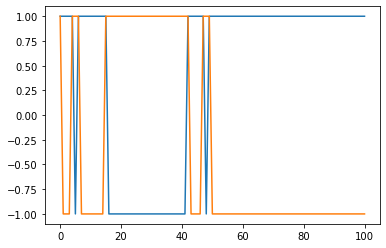

In [24]:
plt.figure(2)
plt.plot(rewards1)
plt.plot(rewards2)
plt.show()

In [23]:
import matplotlib.pyplot as plt

In [25]:
#for rendering purposes

import gym
from gym import error, spaces, utils
from gym.core import ObservationWrapper
from gym.utils import seeding
import numpy as np
import math

import pygame
import sys

from pygame import Color, display, draw, event, font, key, mouse, Rect, Surface, time

class Kickenv(gym.Env):
    
    def __init__(self,di :float,vp : float,lenbar :float, wbar:float, display_width = 750 + 50, display_height = 750 + 50, fps=1):

        '''Constructor for our environment. Should take any relevant parameters as arguments.

        Parameters
        ----------
        di : float
            diameter of puck
        vp : float
            horizontal velocity of puck
        lenbar : float 
            length of the bar
        wbar : float 
            width of the bar

        Ideal Settings :
        BallDiameter = ScreenWidth / 64;
        BarWidth = Settings.BallDiameter / 2;
        BarLength = ScreenHeight / 6;
        BallStartingPosX = ScreenWidth / 8;
        BallStartingPosY = ScreenHeight / 2;
        BarStartingPosX = 7*ScreenWidth/8;
        BarStartingPosY = BallStartingPosY;
        FinalLine =BarStartingPosX + 3*BarWidth;        
        BallSpeed = ScreenWidth / 100
        '''
        # For simplicity only allow odd number of states.
        self.xi=-0.75
        self.yi=0
        
        self.xib=0.75
        self.yib=0
        self.r=di/2
        self.g=0.77
        self.vbar=0
        self.theta=1
        self.vp=vp
        self.lenbar=lenbar
        self.wbar=wbar    
        self.statep=[self.xi,self.yi]
        self.stateb=[self.xib,self.yib]
        self.timestepcounter=0
        self.theta_arr=np.zeros(math.ceil((self.g-self.xi)/self.vp))
        self.action_spacep=spaces.Box(low=-1,high=1,shape=(1,),dtype=np.float32)
        self.action_spaceb=spaces.Box(low=-1,high=1,shape=(1,),dtype=np.float32)
        self.observation_spacep=spaces.Box(low=np.array([-1.0+self.r,-1.0+self.r]),high=np.array([1.0-self.r,1.0-self.r]),shape=(2,))
        self.observation_spaceb=spaces.Box(low=-1+self.lenbar/2,high=1-(self.lenbar/2),shape=(1,))
        self.donep=False
        self.doneb=False
        self.rewardp=0
        self.statepr=self.statep
        self.rewardb=0
        
        pygame.init()
        display.init()

        self.display_width = display_width
        self.display_height = display_height

        self.currentDisplaySurface = display.set_mode((display_width, display_height))
        
        display.set_caption("Penalty Shot Game")

        self.Clock = time.Clock()  
        self.fps = fps

        self.black = (0,0,0)
        self.white = (255,255,255)
        self.cellgreen = (0,230,0)

        self.currentDisplaySurface.fill((255, 255, 255))
        self.puckRad = int(self.r * 375)
        
        self.makeTable()
        self.goalLine()
        self.makePuck()
        self.makeBar()
        self.startLine()

        
    def step(self,action) :
        '''Defines what to do if an action is taken.

        Parameters
        ----------
        action : list of actions taken by the puck and bar respectively
            Action  taken.  

        Returns
        -------
        tuple[int, float, bool, None]
            A tuple containing the next state, reward obtained, whether terminal state has been reached, and None.
        '''
        """
        """
        
        self.donep=False
        self.doneb=False
        posbar=self.stateb
        self.theta_arr[self.timestepcounter]=action[1]
        action[0]=action[0]*self.vp
        if(self.timestepcounter>=2):
            if action[1]>=0.8:
                if self.theta_arr[self.timestepcounter-1]>=0.8 and self.theta_arr[self.timestepcounter-2]>=0.8 :
                    self.theta=self.theta+0.85
            elif action[1]<=-0.8 :
                if self.theta_arr[self.timestepcounter-1]<=-0.8 and self.theta_arr[self.timestepcounter-2]<=0.8 :
                    self.theta=self.theta+0.85
            else : self.theta=1
        else : self.theta=1            
        vw=self.theta*self.vp*(2/3)
        statebr=self.stateb
        self.stateb[1]=max(self.observation_spaceb.low,min(self.observation_spaceb.high,self.stateb[1]+action[1]*vw))
        self.statepr=self.statep
        self.statep[0]=self.statep[0]+self.vp
        self.statep[1]=max(self.observation_spacep.low[1],min(self.observation_spacep.high[1],self.statep[1]+action[0]))
        self.rewardp=0
        self.rewardb=0
        if abs(self.statep[0]-posbar[0])<=self.r+self.wbar/2 and abs(self.statep[1]-posbar[1])<=self.r+self.lenbar/2 :
            self.rewardp=-1
            self.rewardb=1
            self.donep=True
        if self.statep[0]>=self.xib and self.statepr[0]<=self.xib and self.donep==False:
            self.donep=True
            self.rewardp=1
            self.rewardb=-1
            self.statep[0]=self.xib-self.wbar-self.r 
        if self.statep[0]+self.r>=self.g and self.donep==False:
            self.donep=True
            self.rewardp=1
            self.rewardb=-1 
            

        return self.statep,self.stateb,self.rewardp,self.rewardb,self.donep,self.doneb,None



    def reset(self):
        '''What to do if we reset the environment.
        '''
        # We simply make our current state equal to initial state .
        # We change the status of completion of our episode[self.done variable] to False.
        # make timestepcounter=0
        #change parameters such a theta and prev_dir to 1 and 0 respectively.
        # Return state and status of completion 
        self.statep =[self.xi,self.yi]
        self.donep=False
        self.doneb=False
        self.stateb=[self.xib,self.yib]
        self.prev_dir=0
        self.theta=1
        self.theta_arr=np.zeros(math.ceil((self.g-self.xi)/self.vp))
        self.statepr=self.statep
        self.timestepcounter=0
        return self.statep,self.stateb,self.donep,self.doneb    

    def render(self, display_width = 750 + 50, display_height = 750 + 50, fps=1):

        self.Clock.tick(self.fps)
        display.update()

        puckx, pucky = self.statep
        bary = self.stateb[1]

        self.puckX = (puckx+1)*375 + 25
        self.puckY = (pucky-1)*(-375) + 25
        self.barY = (bary-1)*(-375) + 25

        self.currentDisplaySurface.fill((255, 255, 255))
        self.makeTable()
        self.goalLine()
        self.startLine()

        self.shiftPuck()
        self.shiftBar()
        
    def makeTable(self):
        borderWidth = 1
        top = 25
        left = 25

        tableRect = Rect(left , top , self.display_width - 50, self.display_height - 50)

        draw.rect(self.currentDisplaySurface, self.black, tableRect, borderWidth)

    def goalLine(self):
        lineWidth = 1
        borderWidth = 1
        if (borderWidth > self.vp * 375):
            borderWidth = self.vp * 375

        self.goalx = (self.g + 1)*375 + 25

        draw.line(self.currentDisplaySurface, (100,100,150), (self.goalx, 25), (self.goalx, self.display_height - 25), lineWidth)

    def startLine(self):
        lineWidth = 1
        borderWidth = 10

        self.startx = (-0.75 + 1)*375 + 25
        draw.line(self.currentDisplaySurface, (100,100,150), ( self.startx, 25), ( self.startx, self.display_height - 25), lineWidth)

    def makePuck(self):
        self.xi=-0.75
        self.yi=0
        self.puckXinitial = (-0.75 + 1)*375 + 25 - self.puckRad
        self.puckYinitial = (0 + 1)*375 + 25

        self.puckX = self.puckXinitial
        self.puckY = self.puckYinitial
        
        draw.circle(self.currentDisplaySurface, (50,50,250), (self.puckXinitial ,self.puckYinitial), self.puckRad)

    def makeBar(self):
        self.barXinitial = (0.75 + 1)*375 + (self.wbar*375) + 25
        self.barYinitial = (0+1)*375 - (self.lenbar/2)*375 + 25

        self.barX = self.barXinitial
        self.barY = self.barYinitial
        
        tableRect = Rect(self.barXinitial , self.barYinitial ,(self.wbar)*375, (self.lenbar)*375)
        draw.rect(self.currentDisplaySurface, (250,50,50), tableRect)

    def shiftPuck(self):
        draw.circle(self.currentDisplaySurface, (50,50,250), (self.puckX ,self.puckY), self.puckRad)

    def shiftBar(self):
        self.barXinitial = (0.75 + 1)*375 + (self.wbar*375) + 25
        tableRect = Rect(self.barXinitial, self.barY,(self.wbar)*375, (self.lenbar)*375)
        draw.rect(self.currentDisplaySurface, (250,50,50), tableRect)

    def close(self):
        pygame.quit() #Uninitilize all imported pygame modules.


########################################################################################

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [28]:
env = Kickenv(0.03,0.3,0.7,0.01)

/home/aditya/anaconda3/lib/python3.8/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))
